## Análise de estilo dinâmica utilizando Filtro de Kalman

Análise dinâmica de estilo baseada em retornos (DSA, do inglês Dynamic Style Analisys) é uma técnica investigativa que busca identificar a estratégia de um fundo por meio da estimação das frações do portifólio investido em determinados ativos durante um certo intervalo de tempo.

Este notebook demonstra uma forma de se aplicar o filtro de Kalman para estimação dos pesos dos ativos em um portfolio sintético

### Importação de bibiliotecas e definições padrão

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string

from filterpy.common import Saver
from filterpy.kalman import rts_smoother
from filterpy.kalman import KalmanFilter

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

### Ativos 
São definidos 3 ativos (a,b,c) com retornos $r$ aleatóriamente distribuidos da seguinte forma:

$$
\begin{align}
\begin{pmatrix}
r_a\\
r_b\\
r_c
\end{pmatrix}
& \sim 
\mathcal{N}
\begin{pmatrix}
\mu , 
\Sigma
\end{pmatrix};
\end{align}
\Sigma = \sigma \cdot \sigma^T \cdot \rho
$$
com :
$$
\begin{align}
\mu = 
\begin{pmatrix}
0\\
0\\
0
\end{pmatrix};
\sigma = 
\begin{pmatrix}
0.4\\
0.15\\
0.05
\end{pmatrix} * \dfrac{1}{\sqrt{252}};
\rho = 
\begin{pmatrix}
1 & 0.7 & 0\\
0.7 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\end{align}
$$
<br>
a amostra dos retornos de cada ativo são 1000 dias comerciais desde 01/01/2000

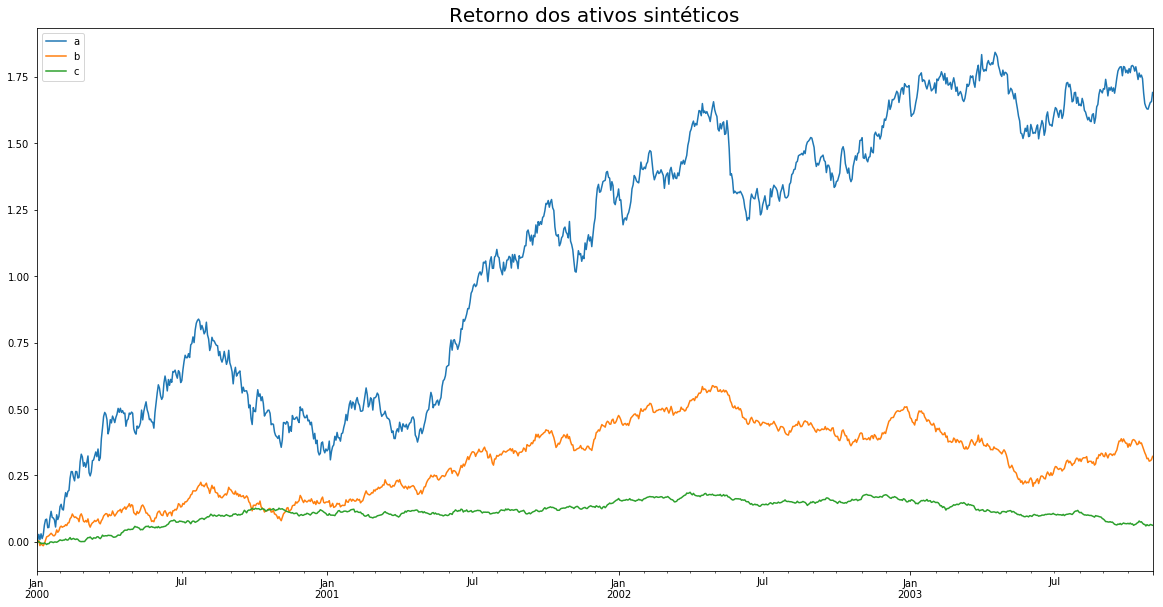

In [2]:
mean = [0, 0, 0]
stds = np.array([0.4, 0.15, 0.05]) / 252 ** 0.5
corr = np.eye(3) 
corr[1,0] = corr[0,1]  = 0.7
cov = np.multiply(np.outer(stds,stds), corr)
returns = np.random.multivariate_normal(mean, cov, 1000)
stock = pd.DataFrame(returns, columns=list(string.ascii_lowercase[:len(mean)]), index=pd.date_range('2000-01-01', freq='B', periods=returns.shape[0]))
stock.cumsum().plot(figsize=(20,10))
plt.title("Retorno dos ativos sintéticos", fontsize='20');

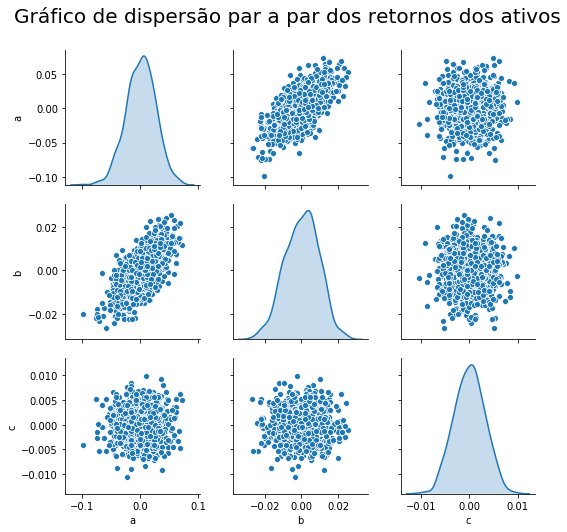

In [3]:
g = sns.pairplot(stock, diag_kind='kde')
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Gráfico de dispersão par a par dos retornos dos ativos", fontsize='20');

## Portfolio
Alocação inicial dada por $\omega_a = 0.5; \ \omega_b = 0.2; \ \omega_c = 0.1$ com probabilidades de realocação P(N=p_x) que seguem uma distribuição binomial sendo: $ \ p_a = 0.02; \ p_b = 0.03; \ p_c=0.01$ e amplitudes de realocação normalmente distribuidos com $\mathcal{N} \sim (0.01, 0.1)$
<br>
em t=600 (22/04/2002) a alocação no ativo a vai a zero e a alocação no ativo c é mantida em 0.25

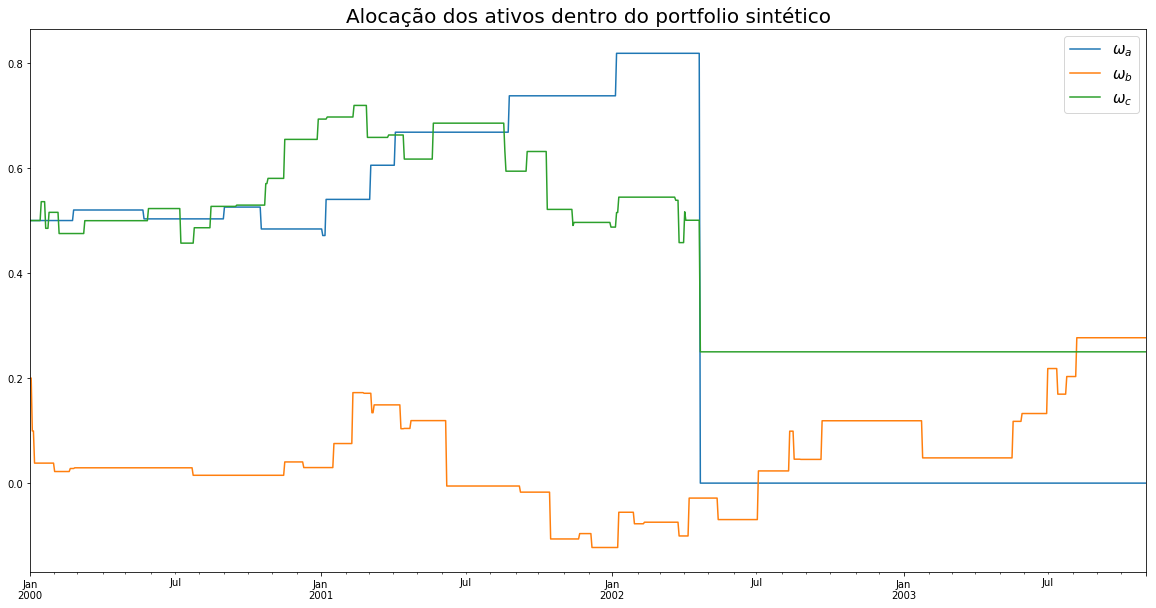

In [6]:
p1 = pd.DataFrame(index=stock.index, columns=stock.columns)
p1[['a','b','c']] = [0.5, 0.2, 0.5]

p1['a'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.02,1000)).cumsum()
p1['b'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.03,1000)).cumsum()
p1['c'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.05,1000)).cumsum()

p1.loc[600:, 'a'] = 0
p1.loc[600:, 'c'] = 0.25

p1_return = p1.mul(stock).sum(1)

p1.plot(figsize=(20,10), legend=False)
plt.title("Alocação dos ativos dentro do portfolio sintético", fontsize='20');
plt.legend(['$\omega_a$','$\omega_b$','$\omega_c$'], fontsize='15');

# Filtro de Kalman
para modelagem foi usada a biblioteca [filterpy](https://filterpy.readthedocs.io/en/latest/) as matrizes foramm definidas da seguinte forma: <br>

Matriz de estados | Matriz de medidas | Matriz de Transição | Matriz ruido do processo | Matriz ruído das medidas  
---|---|---|---|---|
$ X = \begin{bmatrix} \hat{\omega_a} \\ \hat{\omega_b} \\ \hat{\omega_c} \end{bmatrix}; $ | $ Z = \begin{bmatrix} r_p \\ \omega_a \\ \omega_b \\ \omega_c \end{bmatrix}; $ |  $ F = I_3 ; $ |  $ Q = I_3 * 0.0005; $ | $ R = I_4 * 1e-10; $ 

A matriz H converte a matriz de estados X no vetor de medidas Z, afim de calcular-se o erro de projecão e consequente ganho Kalman: 
$ H = \begin{bmatrix} r_a & r_b & r_c  \\ \zeta_a & 0 & 0 \\ 0 & \zeta_b & 0 \\ 0 & 0 & \zeta_c \end{bmatrix} $ <br>

Havendo alguma informação disponível a respeito do peso de determinado ativo no porfolio no tempo t, nesta iteração, o elemento $\zeta$ correspondente da matriz H é setado como 1

ao final é aplicado o algoritimo rts smooth

####  Caso base, nenhuma informação sobre o peso dos ativos

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} $ <br>

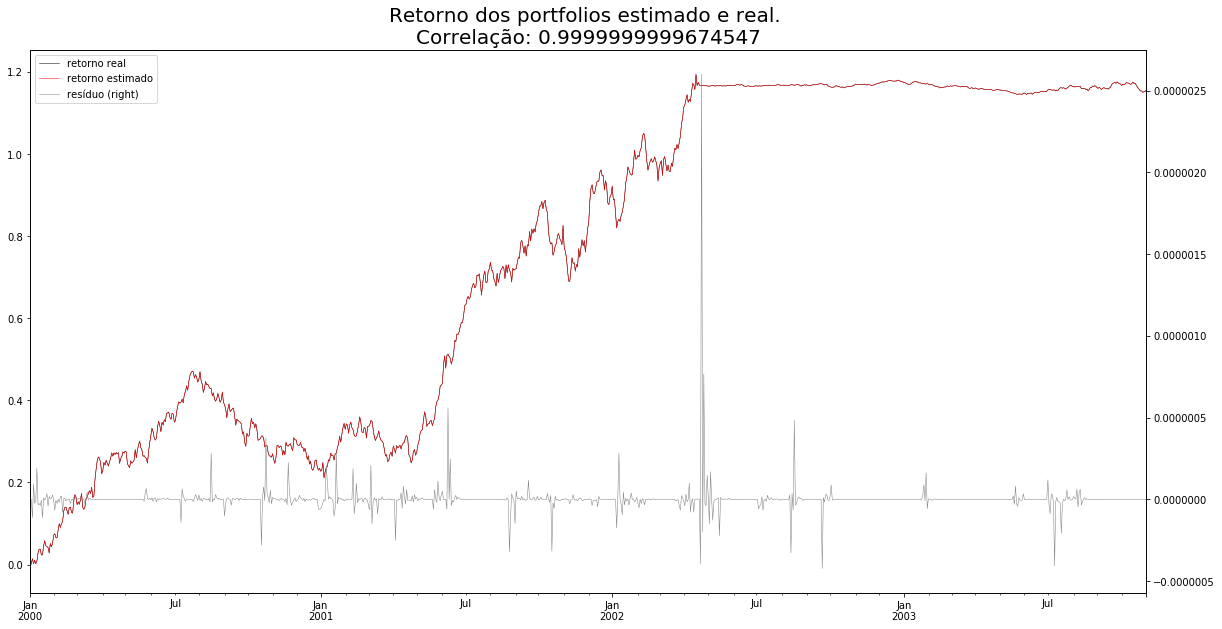

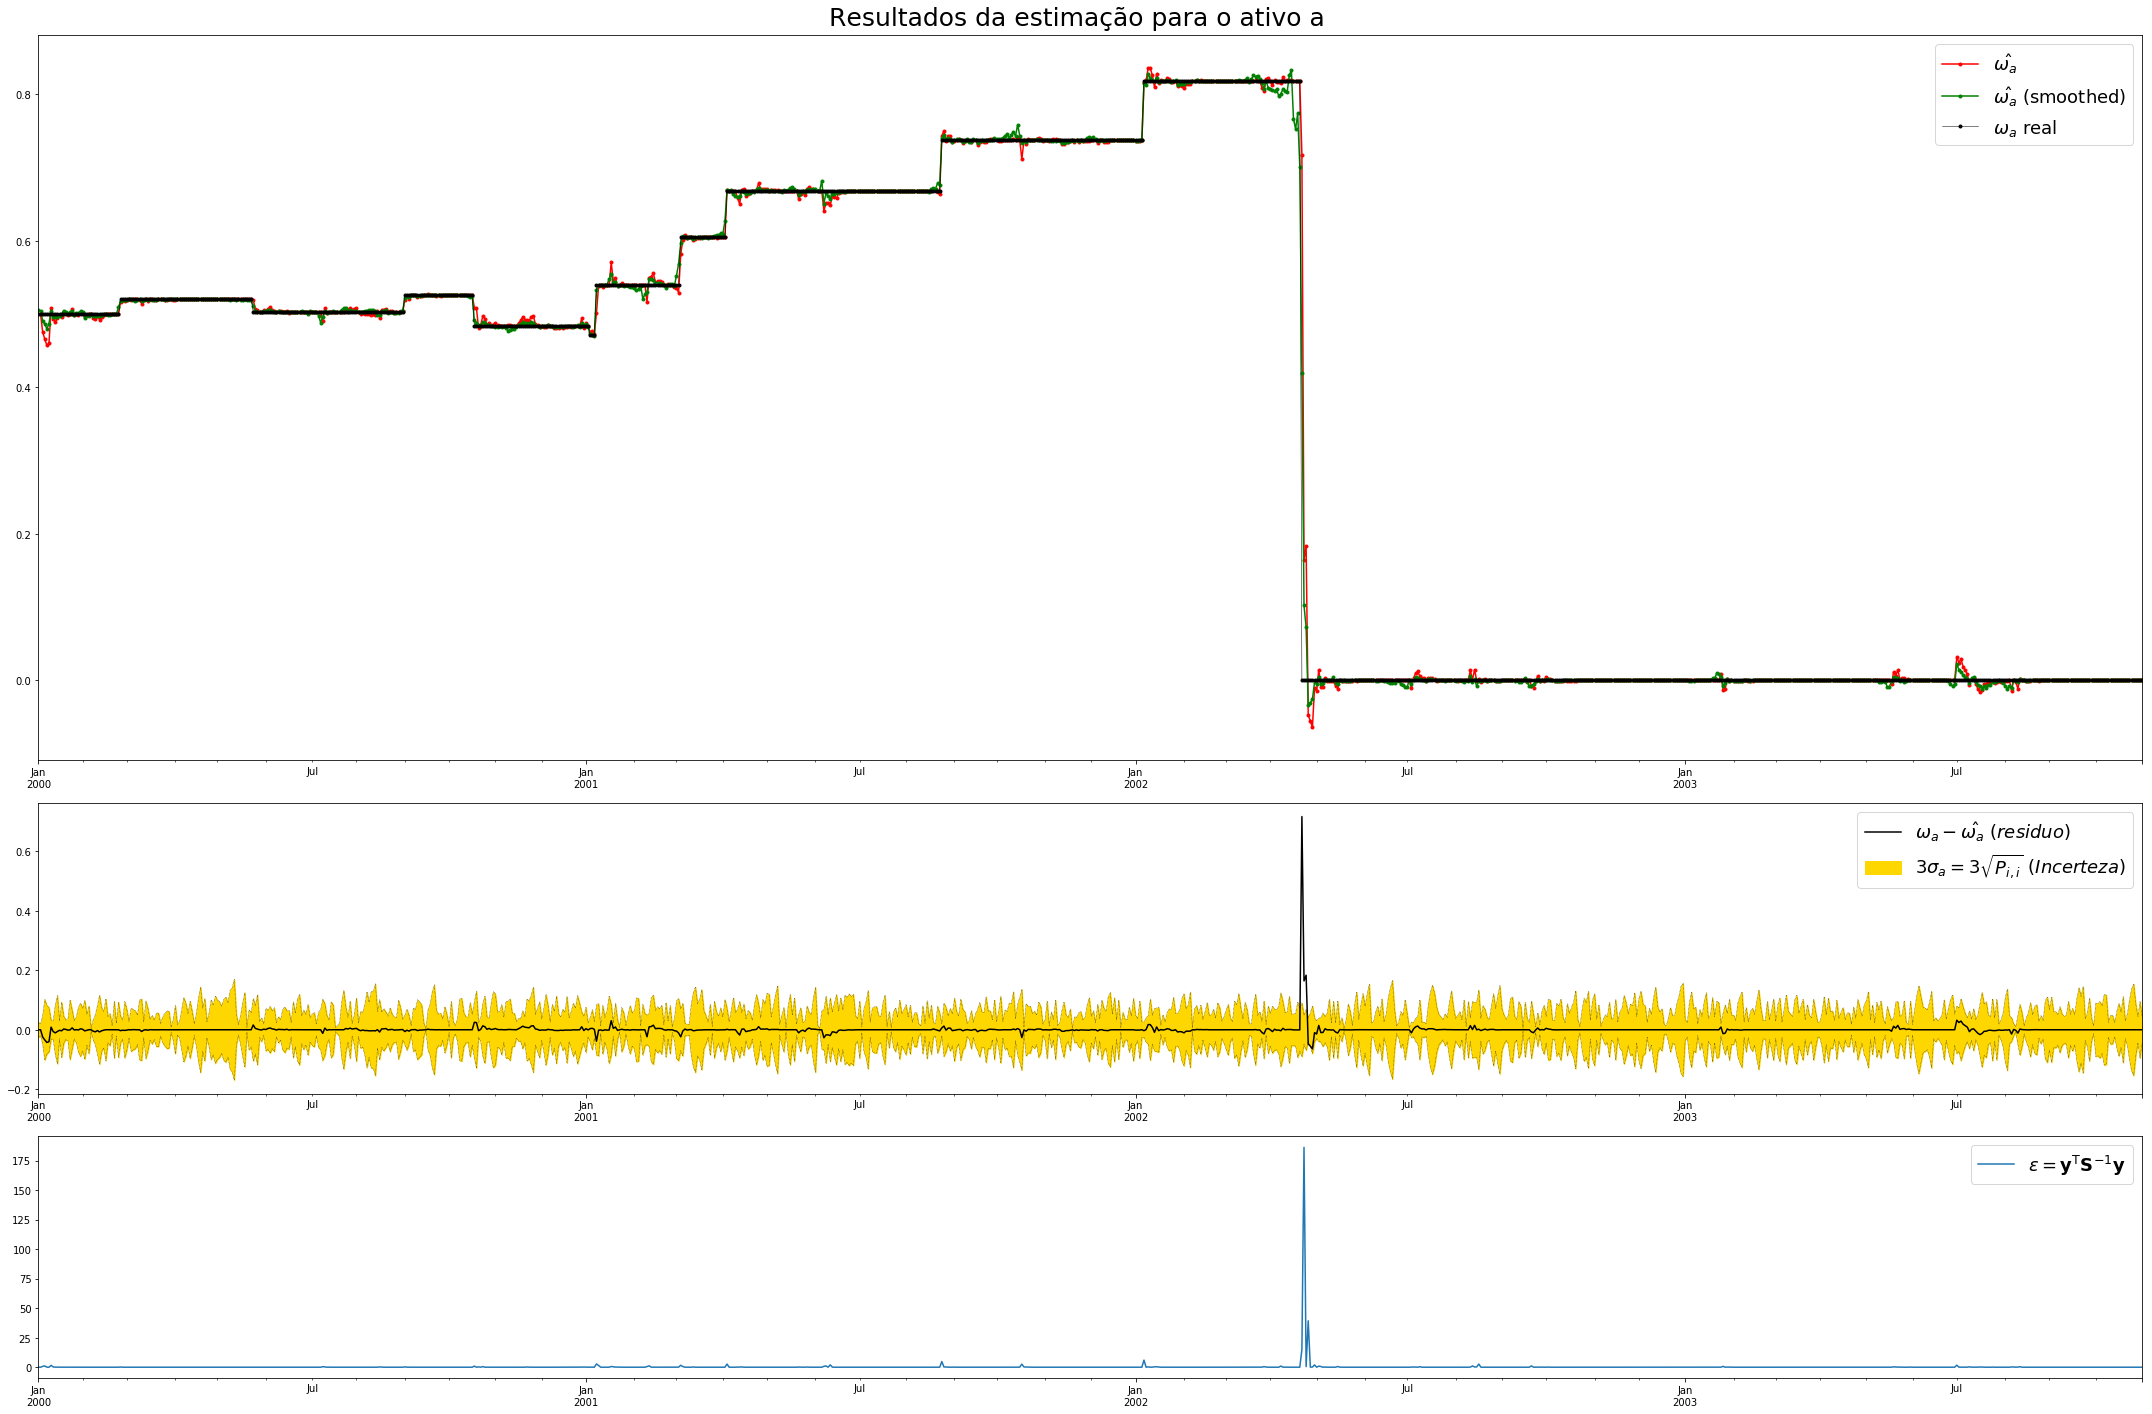

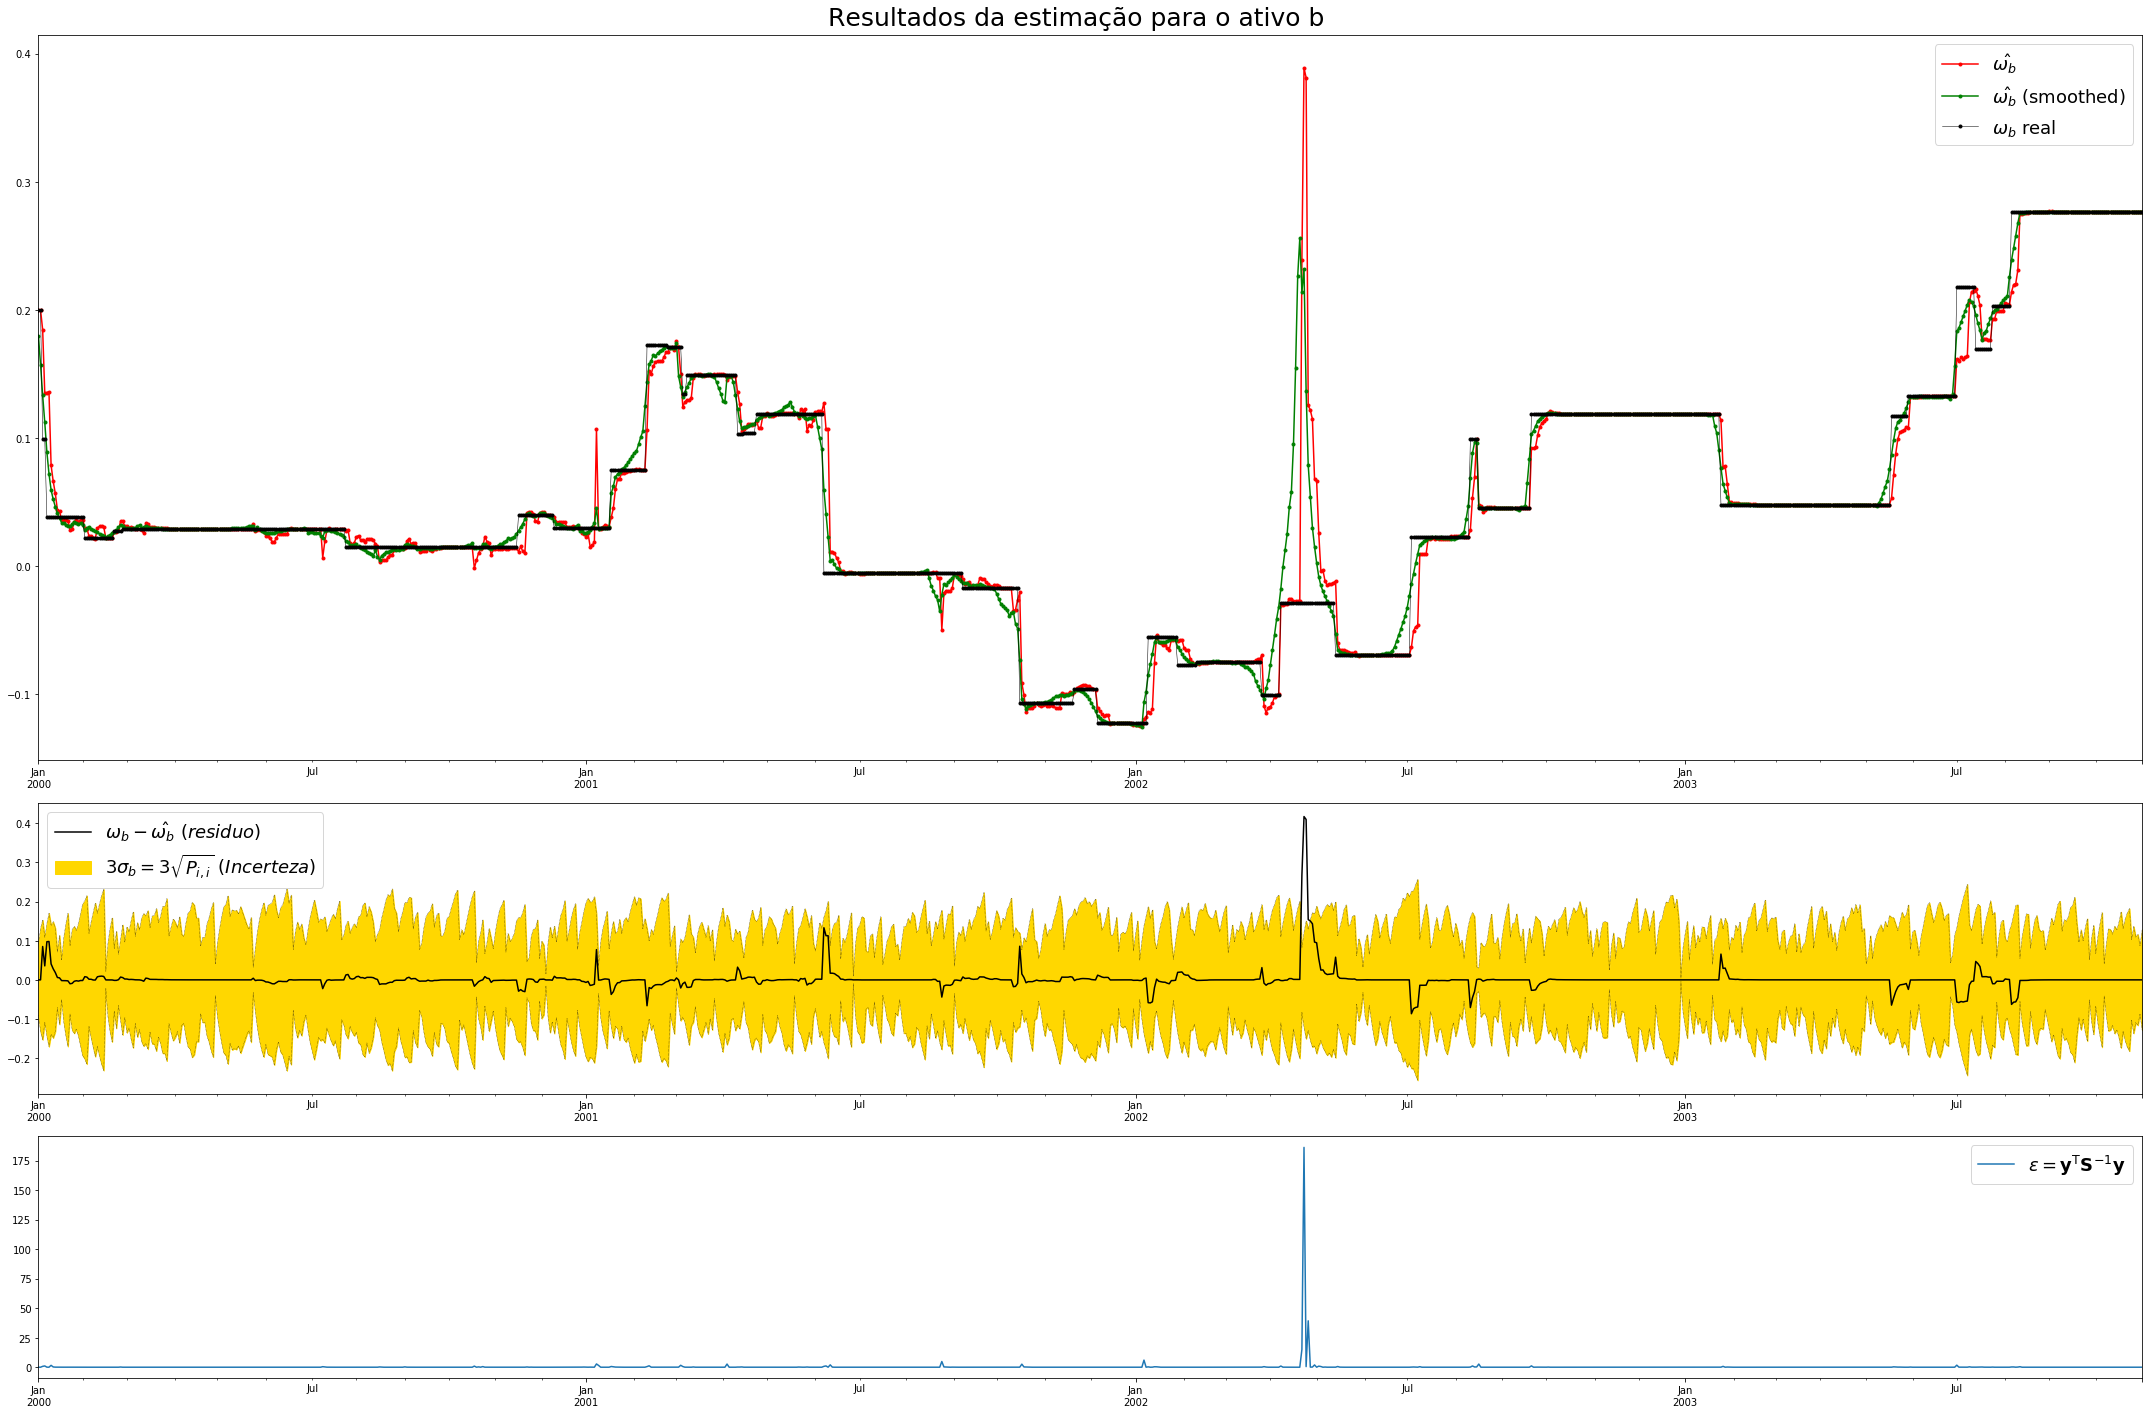

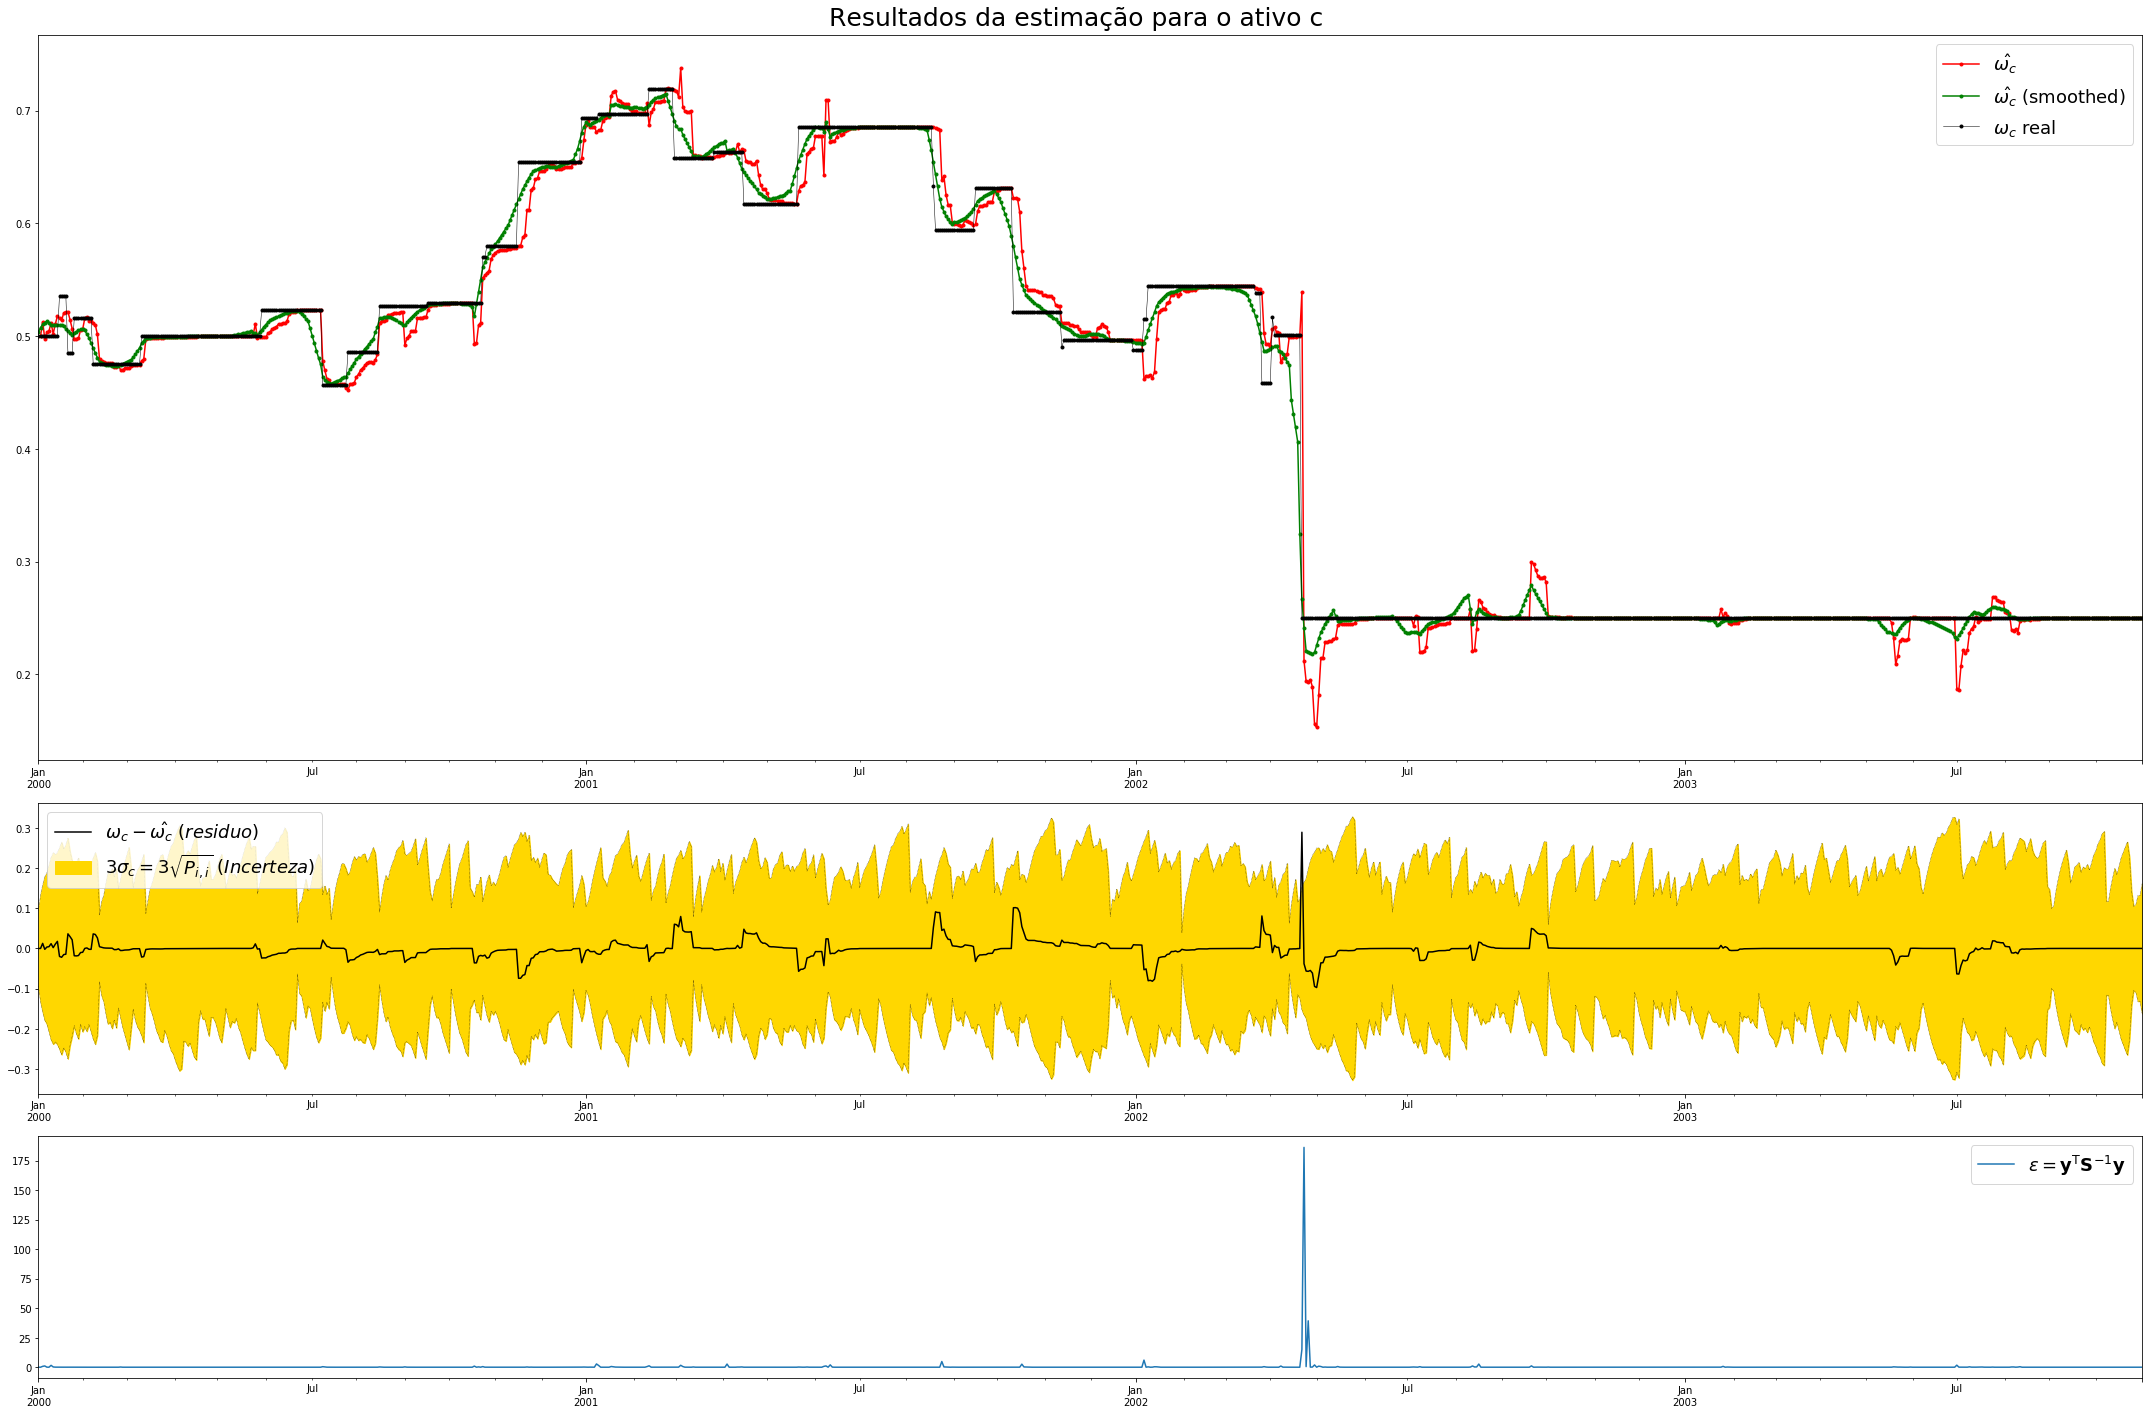

In [14]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3)

#Process Noise Q
kf.Q *= 1e-3

#Exact Initial Guess
kf.x = p1.iloc[0].values
kf.P = np.array([0,0,0])

#Measurement Noise R
kf.R *= 1e-10

#faz o loop para cada data
s = Saver(kf)
epss = []
count = 0
for i,dt in enumerate(stock.index):
    #Measurement Function H
    kf.H = np.zeros((4,3))
    kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

#residuos ao quadrado normalizado
epss = pd.Series(np.array(epss), index=p1.index)

#organização dos dados para o plot
retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
estimativas = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_b}$',r'$\hat{\omega_c}$' ])
estimativas_smooth = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_b}$ (smoothed)',r'$\hat{\omega_c}$ (smoothed)' ])
residuo_estimativa = pd.DataFrame(estimativas.values - p1.values, index=p1.index, columns=['residuo a', 'residuo b', 'residuo c'])
residuo_estimativa_smooth = pd.DataFrame(estimativas_smooth.values - p1.values, index=p1.index, columns=['residuo a (smooth)', 'residuo b (smooth)', 'residuo c (smooth)'])

incerteza = pd.DataFrame(s.P.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3
incerteza_smooth = pd.DataFrame(sP.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
residuo = (p1_return - retorno_estimado)

#plota o retorno do portfolio estimado e os erros
ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o resultado pra cada ativo
for i, c in enumerate(p1.columns):
    fig, (axu, axd, axd2) = plt.subplots(3,1, gridspec_kw=dict(height_ratios=[3,1.2,1]), figsize=(30,20))

    estimativas.iloc[:,i].plot(ax=axu, color='red', linestyle='-', lw=1.5, marker='.')
    estimativas_smooth.iloc[:,i].plot(ax=axu, color='green', linestyle='-', lw=1.5, marker='.')
    p1.iloc[:,i].plot(color='black', linestyle='-', lw=0.5, ax=axu, label=r'$\omega_{}$ real'.format(p1.columns[i]), marker='.')

    residuo_estimativa.iloc[:,i].plot(ax=axd, color='k', label='$\omega_{0} - \hat{{\omega_{0}}}\ (residuo)$'.format(p1.columns[i]))
    #residuo_estimativa_smooth.iloc[:,i].plot(ax=axd, color='green',ls='-')

    area = axd.fill_between(p1.index.to_native_types(), -incerteza.iloc[:,i]*1,incerteza.iloc[:,i]*1, color='gold')
    incerteza.iloc[:,i].mul(1).plot(ax=axd, ls=':', color='k', lw='.5')
    incerteza.iloc[:,i].mul(-1).plot(ax=axd, ls=':', color='k', lw='.5')

    #pd.DataFrame(s.y).iloc[:,0].plot(ax=axd2)
    epss.plot(label="$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$", ax=axd2)

    axu.legend(fontsize=18)
    handlers, labels = axd.get_legend_handles_labels()
    axd.legend(handlers[:-2] + [area], labels[:-2] + ['$ 3\sigma_{} = 3\sqrt{{P_{{i,i}}}} \ (Incerteza)$'.format(p1.columns[i])], fontsize=18)

    axd2.legend(fontsize=18)

    fig.suptitle("Resultados da estimação para o ativo {}".format(p1.columns[i]), fontsize=25);
    plt.tight_layout(rect=[0,0,1,0.97])



####  Caso alternativo 1, informação sobre os peso dos ativos na quebra estrutural (t = 600)

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix};  $ $ H_{t=600} = \begin{bmatrix} r_a & r_b & r_c  \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $ <br>

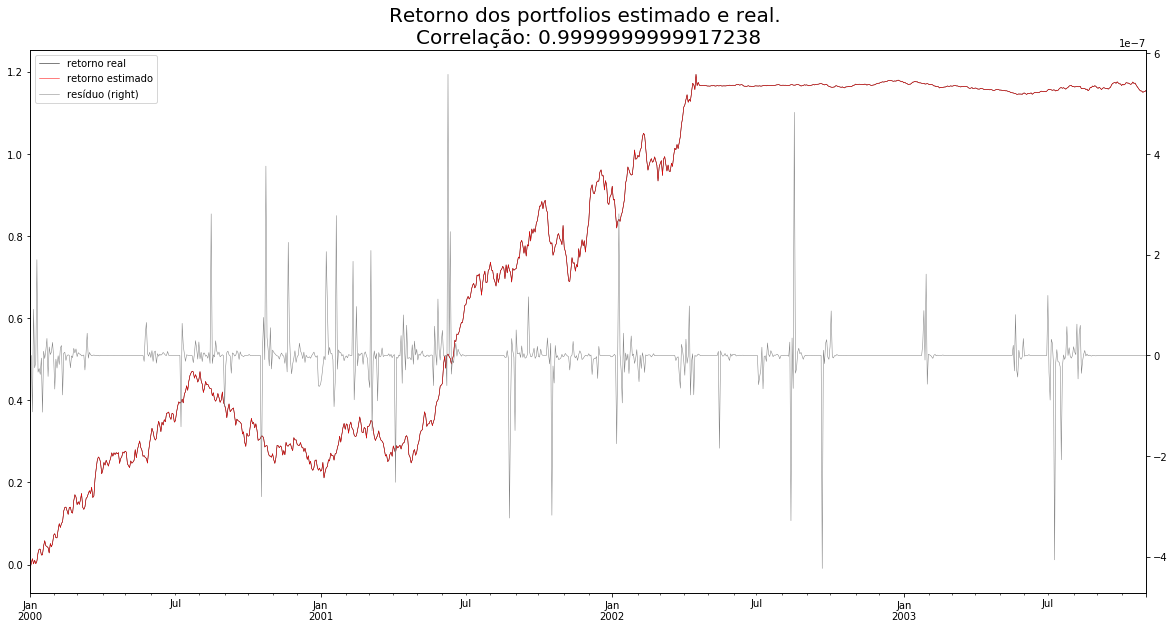

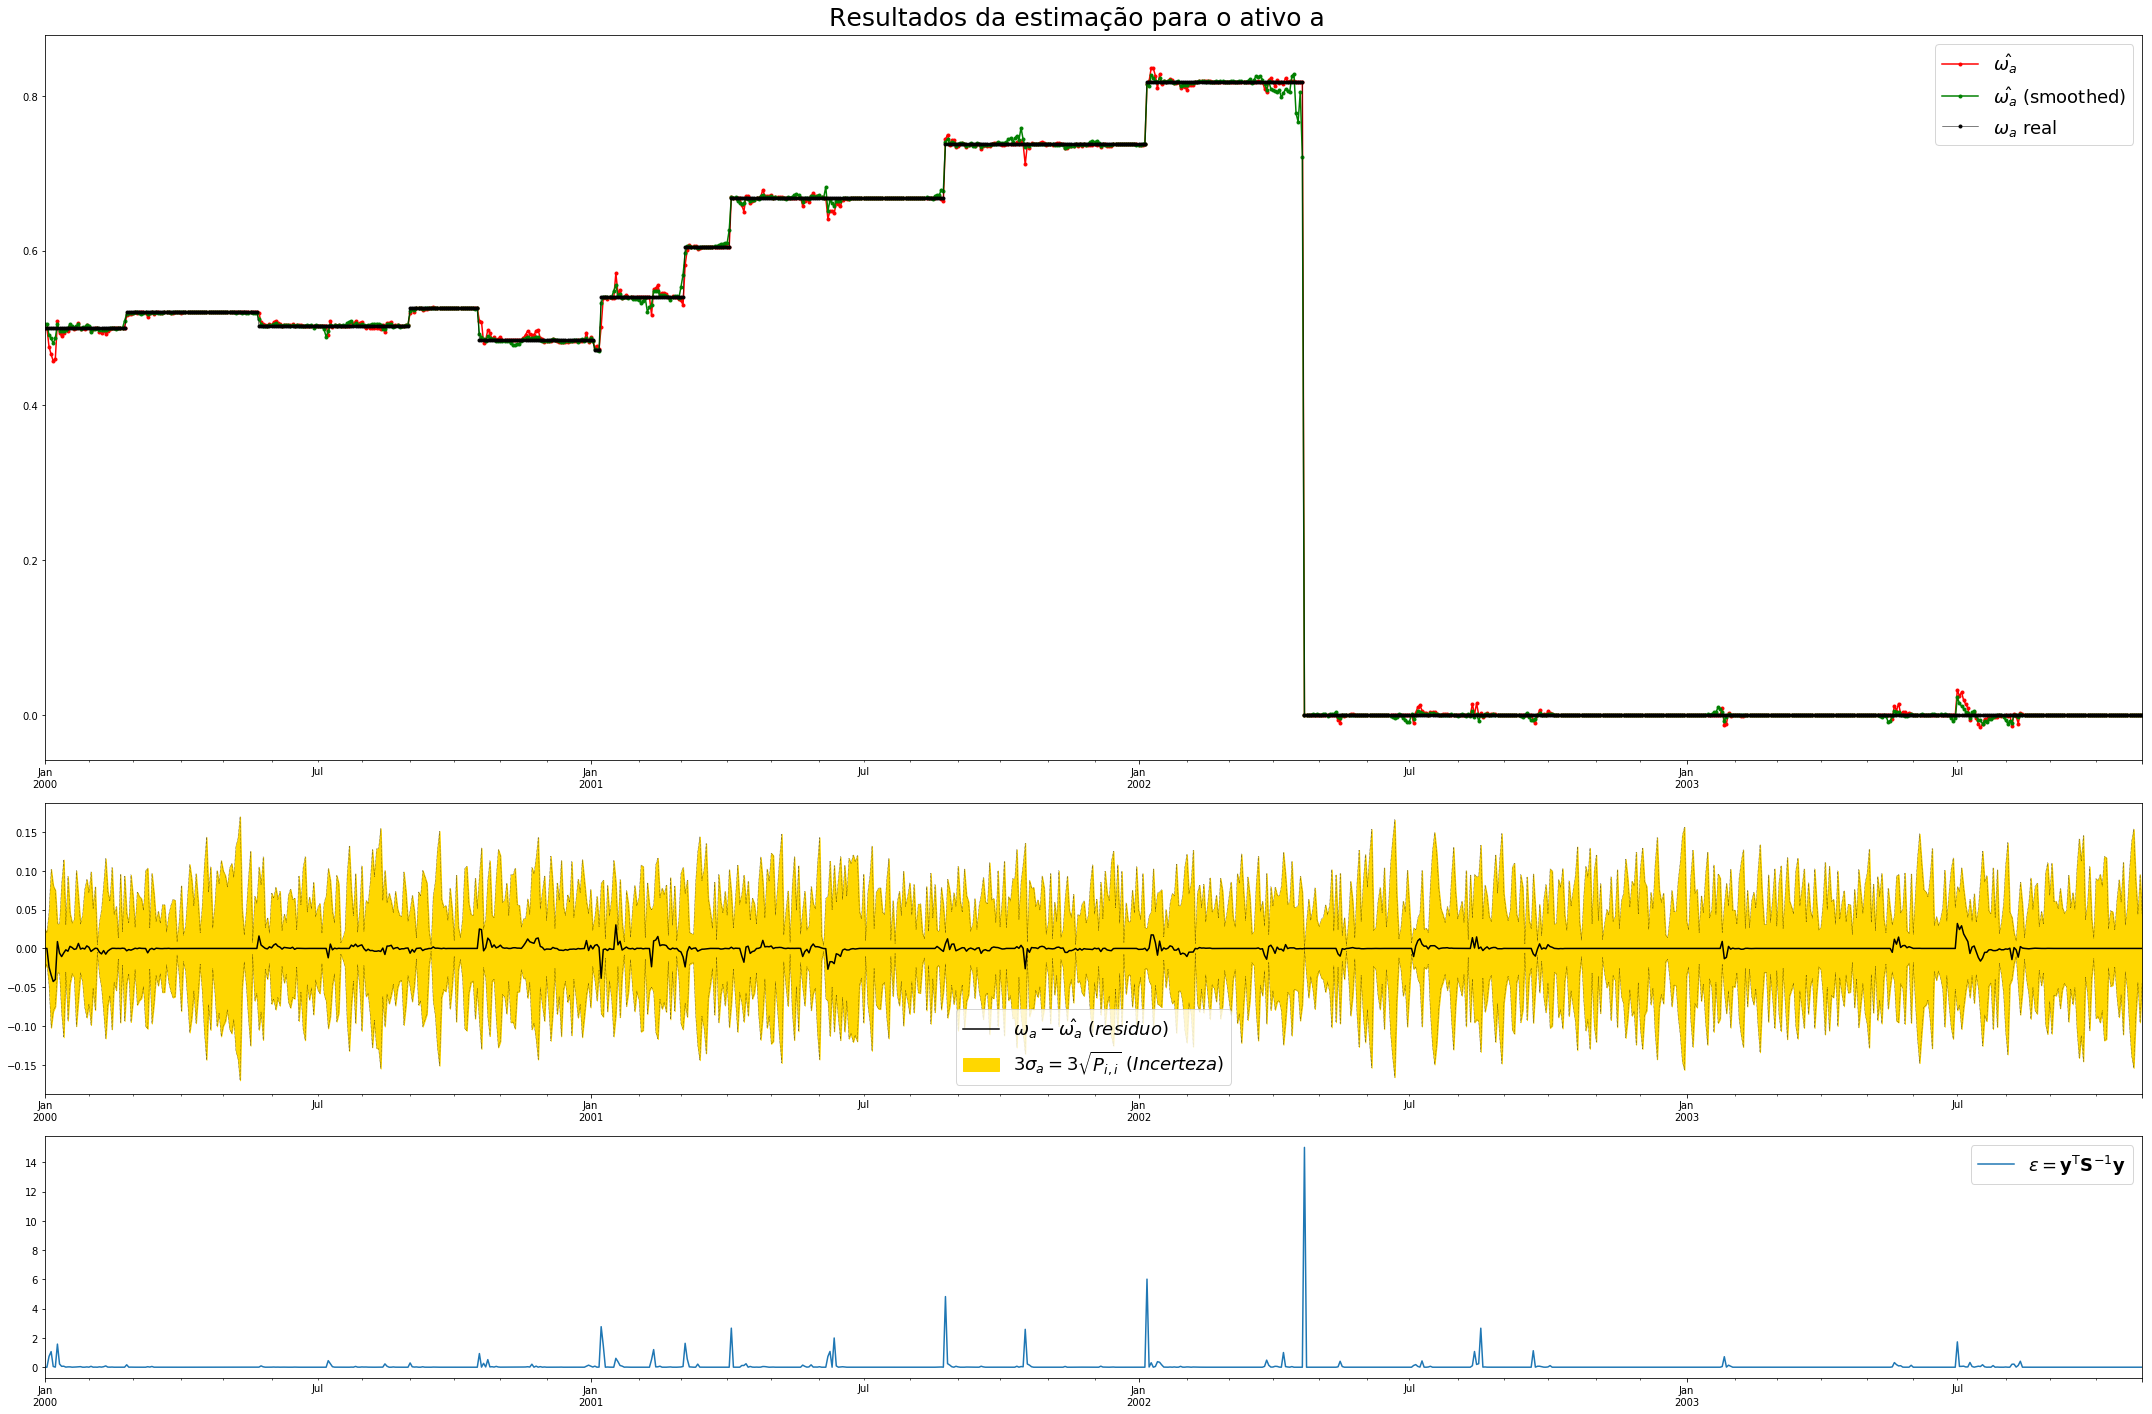

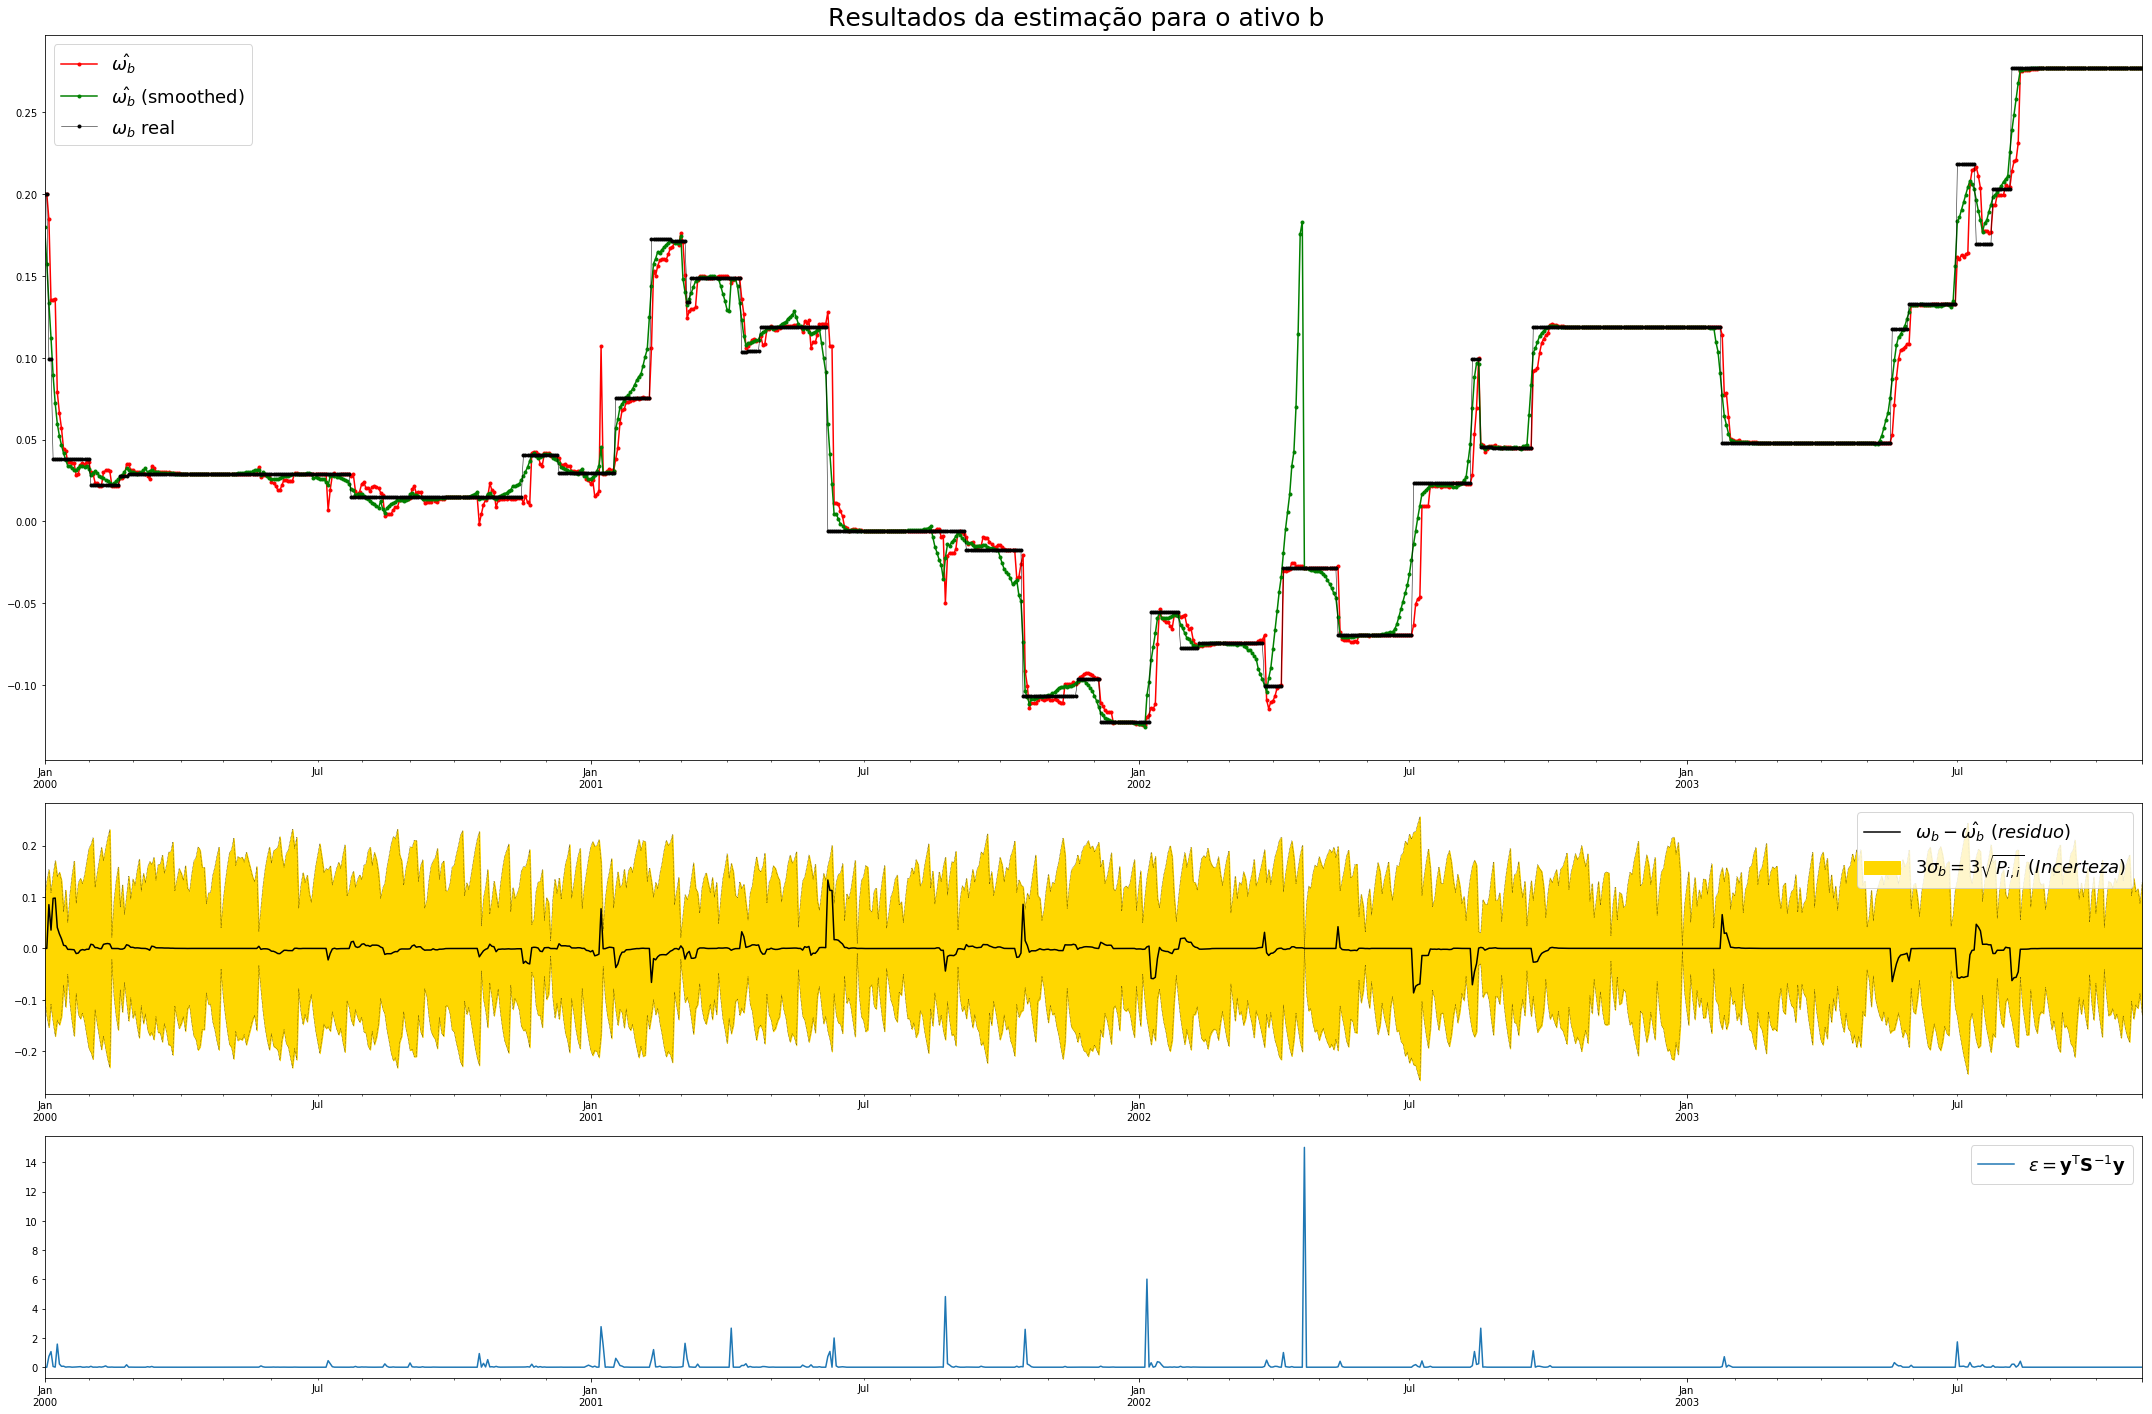

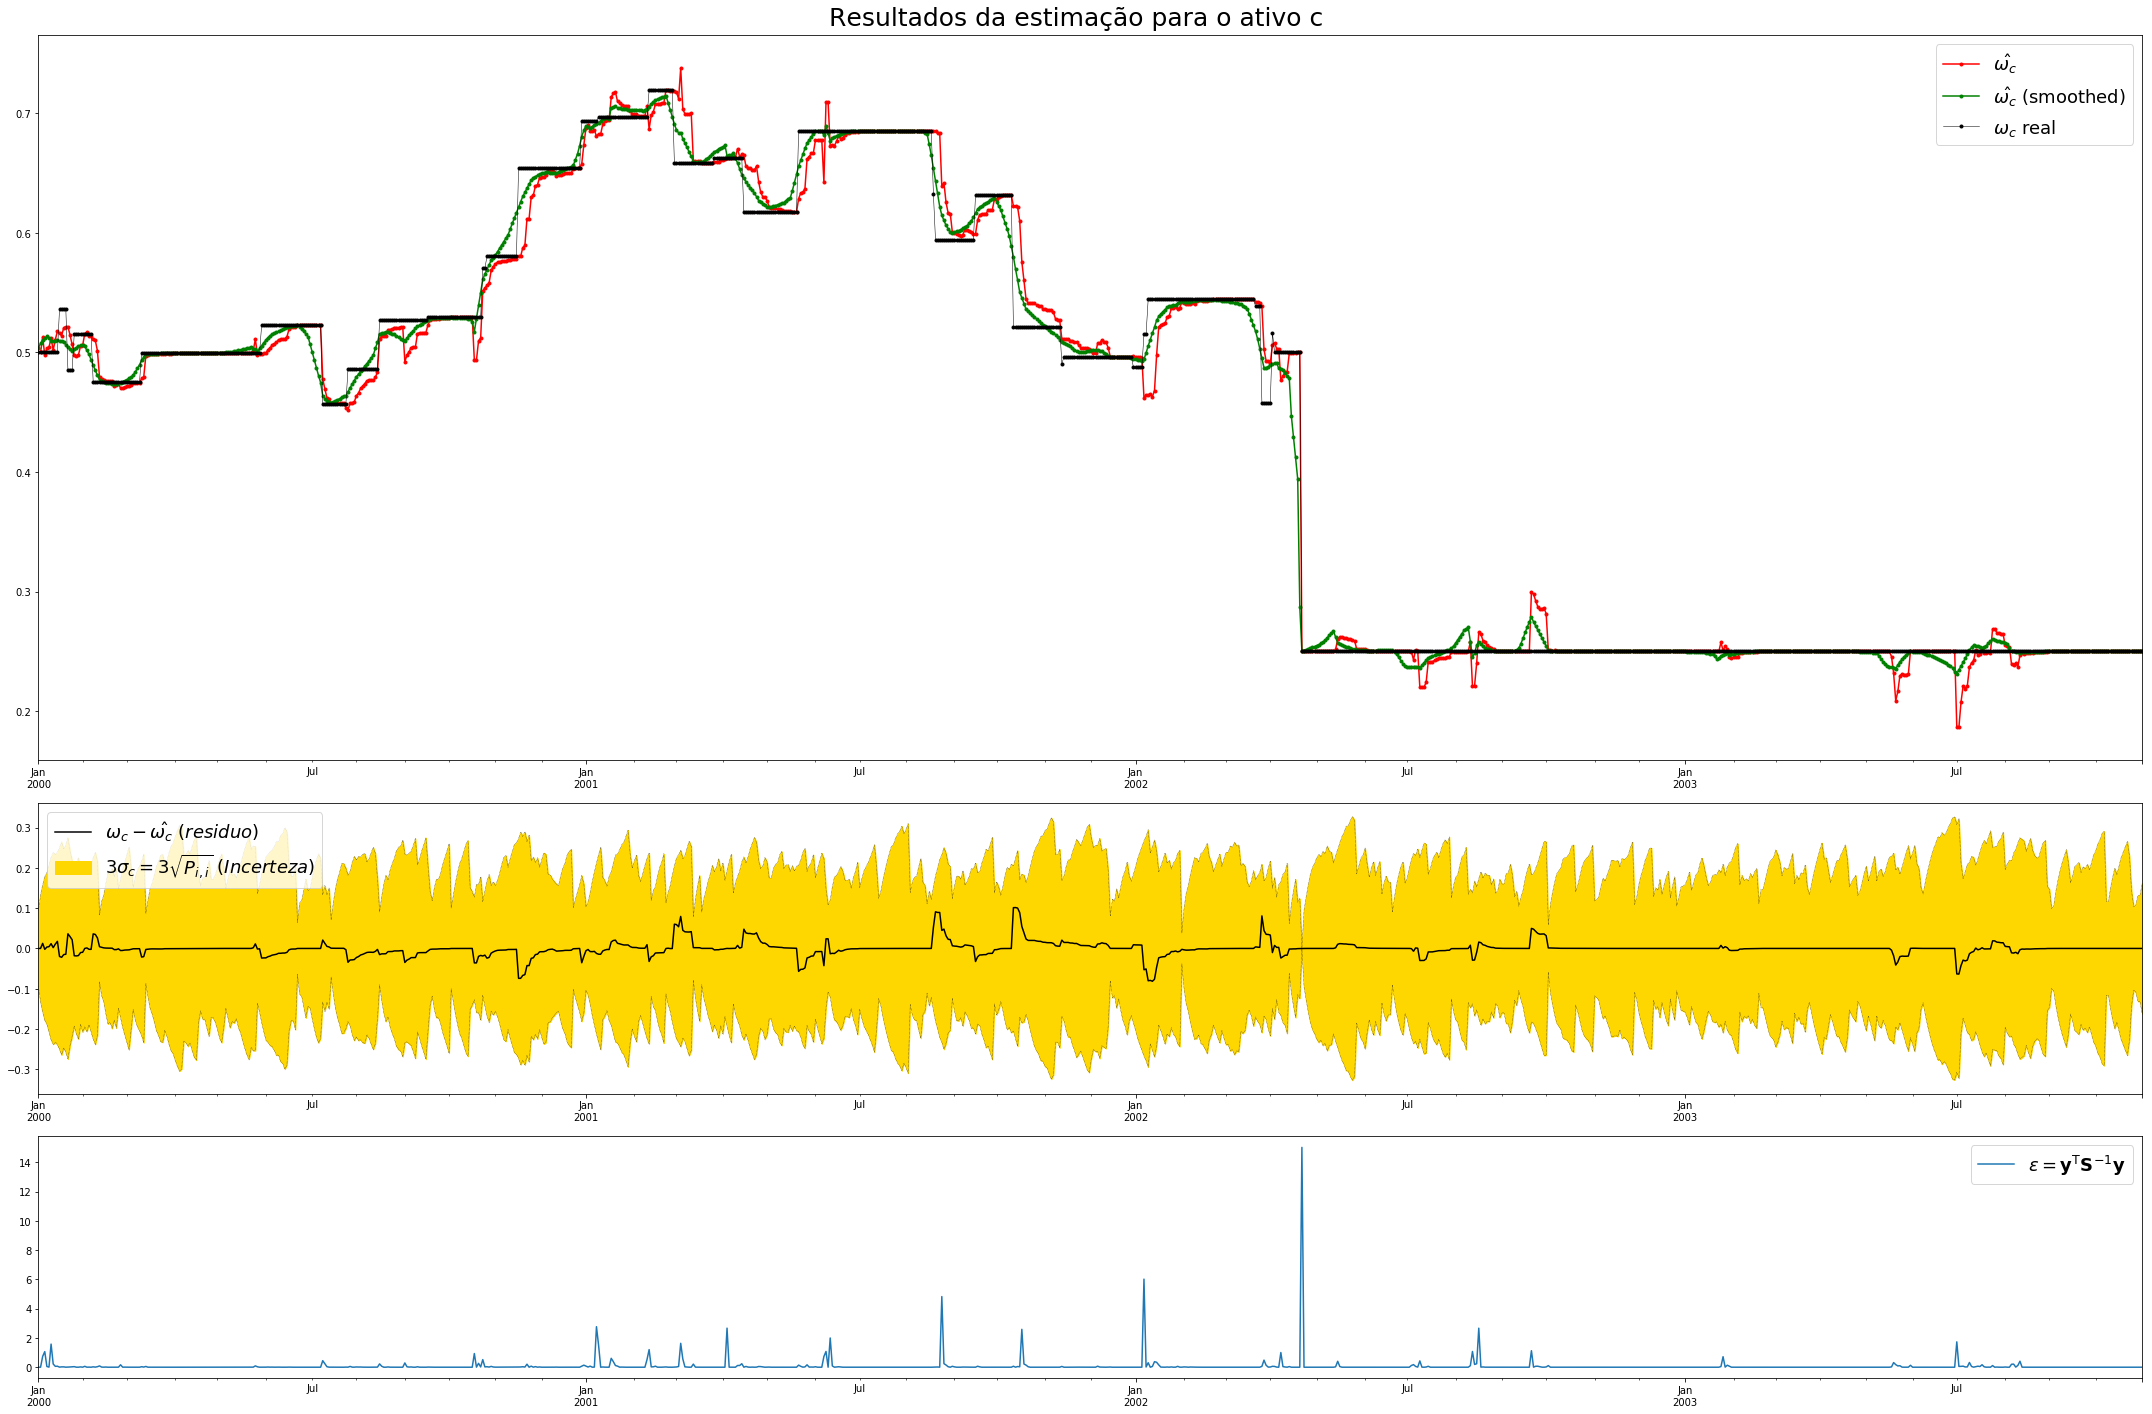

In [13]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3)

#Process Noise Q
kf.Q *= 1e-3

#Exact Initial Guess
kf.x = p1.iloc[0].values
kf.P = np.array([0,0,0])

#Measurement Noise R
kf.R *= 1e-10

#faz o loop para cada data
s = Saver(kf)
epss = []
count = 0
for i,dt in enumerate(stock.index):
    #Measurement Function H
    if i == 600:
        kf.H = np.vstack([stock.loc[dt].values.reshape(1,3), np.eye(3)])
    else:
        kf.H = np.zeros((4,3))
        kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

#residuos ao quadrado normalizado
epss = pd.Series(np.array(epss), index=p1.index)

#organização dos dados para o plot
retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
estimativas = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_b}$',r'$\hat{\omega_c}$' ])
estimativas_smooth = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_b}$ (smoothed)',r'$\hat{\omega_c}$ (smoothed)' ])
residuo_estimativa = pd.DataFrame(estimativas.values - p1.values, index=p1.index, columns=['residuo a', 'residuo b', 'residuo c'])
residuo_estimativa_smooth = pd.DataFrame(estimativas_smooth.values - p1.values, index=p1.index, columns=['residuo a (smooth)', 'residuo b (smooth)', 'residuo c (smooth)'])

incerteza = pd.DataFrame(s.P.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3
incerteza_smooth = pd.DataFrame(sP.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
residuo = (p1_return - retorno_estimado)

#plota o retorno do portfolio estimado e os erros
ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o resultado pra cada ativo
for i, c in enumerate(p1.columns):
    fig, (axu, axd, axd2) = plt.subplots(3,1, gridspec_kw=dict(height_ratios=[3,1.2,1]), figsize=(30,20))

    estimativas.iloc[:,i].plot(ax=axu, color='red', linestyle='-', lw=1.5, marker='.')
    estimativas_smooth.iloc[:,i].plot(ax=axu, color='green', linestyle='-', lw=1.5, marker='.')
    p1.iloc[:,i].plot(color='black', linestyle='-', lw=0.5, ax=axu, label=r'$\omega_{}$ real'.format(p1.columns[i]), marker='.')

    residuo_estimativa.iloc[:,i].plot(ax=axd, color='k', label='$\omega_{0} - \hat{{\omega_{0}}}\ (residuo)$'.format(p1.columns[i]))
    #residuo_estimativa_smooth.iloc[:,i].plot(ax=axd, color='green',ls='-')

    area = axd.fill_between(p1.index.to_native_types(), -incerteza.iloc[:,i]*1,incerteza.iloc[:,i]*1, color='gold')
    incerteza.iloc[:,i].mul(1).plot(ax=axd, ls=':', color='k', lw='.5')
    incerteza.iloc[:,i].mul(-1).plot(ax=axd, ls=':', color='k', lw='.5')

    #pd.DataFrame(s.y).iloc[:,0].plot(ax=axd2)
    epss.plot(label="$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$", ax=axd2)

    axu.legend(fontsize=18)
    handlers, labels = axd.get_legend_handles_labels()
    axd.legend(handlers[:-2] + [area], labels[:-2] + ['$ 3\sigma_{} = 3\sqrt{{P_{{i,i}}}} \ (Incerteza)$'.format(p1.columns[i])], fontsize=18)

    axd2.legend(fontsize=18)

    fig.suptitle("Resultados da estimação para o ativo {}".format(p1.columns[i]), fontsize=25);
    plt.tight_layout(rect=[0,0,1,0.97])

####  Caso 3, informação dos ativos ao final de cada Mês

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix};  $ $ H_{ (se \ t \ é \ fim \ do \ mes)} \begin{bmatrix} r_a & r_b & r_c  \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $ <br>

In [ ]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3)

#Process Noise Q
kf.Q *= 1e-3

#Exact Initial Guess
kf.x = p1.iloc[0].values
kf.P = np.array([0,0,0])

#Measurement Noise R
kf.R *= 1e-1

#faz o loop para cada data
s = Saver(kf)
epss = []
count = 0
for i,dt in enumerate(stock.index):
    #Measurement Function H
    if pd.offsets.MonthEnd().onOffset(dt) | ( i == 600):
        kf.H = np.vstack([stock.loc[dt].values.reshape(1,3), np.eye(3)])
    else:
        kf.H = np.zeros((4,3))
        kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

#residuos ao quadrado normalizado
epss = pd.Series(np.array(epss), index=p1.index)

#organização dos dados para o plot
retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
estimativas = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_b}$',r'$\hat{\omega_c}$' ])
estimativas_smooth = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_b}$ (smoothed)',r'$\hat{\omega_c}$ (smoothed)' ])
residuo_estimativa = pd.DataFrame(estimativas.values - p1.values, index=p1.index, columns=['residuo a', 'residuo b', 'residuo c'])
residuo_estimativa_smooth = pd.DataFrame(estimativas_smooth.values - p1.values, index=p1.index, columns=['residuo a (smooth)', 'residuo b (smooth)', 'residuo c (smooth)'])

incerteza = pd.DataFrame(s.P.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3
incerteza_smooth = pd.DataFrame(sP.diagonal(axis1=1, axis2=2), index=stock.index, columns=[r"$\sigma_{}$".format(s) for s in "abc"]).pow(0.5) * 3

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
residuo = (p1_return - retorno_estimado)

#plota o retorno do portfolio estimado e os erros
ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o resultado pra cada ativo
for i, c in enumerate(p1.columns):
    fig, (axu, axd, axd2) = plt.subplots(3,1, gridspec_kw=dict(height_ratios=[3,1.2,1]), figsize=(30,20))

    estimativas.iloc[:,i].plot(ax=axu, color='red', linestyle='-', lw=1.5, marker='.')
    estimativas_smooth.iloc[:,i].plot(ax=axu, color='green', linestyle='-', lw=1.5, marker='.')
    p1.iloc[:,i].plot(color='black', linestyle='-', lw=0.5, ax=axu, label=r'$\omega_{}$ real'.format(p1.columns[i]), marker='.')

    residuo_estimativa.iloc[:,i].plot(ax=axd, color='k', label='$\omega_{0} - \hat{{\omega_{0}}}\ (residuo)$'.format(p1.columns[i]))
    #residuo_estimativa_smooth.iloc[:,i].plot(ax=axd, color='green',ls='-')

    area = axd.fill_between(p1.index.to_native_types(), -incerteza.iloc[:,i]*1,incerteza.iloc[:,i]*1, color='gold')
    incerteza.iloc[:,i].mul(1).plot(ax=axd, ls=':', color='k', lw='.5')
    incerteza.iloc[:,i].mul(-1).plot(ax=axd, ls=':', color='k', lw='.5')

    #pd.DataFrame(s.y).iloc[:,0].plot(ax=axd2)
    epss.plot(label="$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$", ax=axd2)

    axu.legend(fontsize=18)
    handlers, labels = axd.get_legend_handles_labels()
    axd.legend(handlers[:-2] + [area], labels[:-2] + ['$ 3\sigma_{} = 3\sqrt{{P_{{i,i}}}} \ (Incerteza)$'.format(p1.columns[i])], fontsize=18)

    axd2.legend(fontsize=18)

    fig.suptitle("Resultados da estimação para o ativo {}".format(p1.columns[i]), fontsize=25);
    plt.tight_layout(rect=[0,0,1,0.97])